# Original given implementation for DDPG

This notebook was the given implementation of DDPG as a basis for our project in the course "robot programming" at the University of Applied Sciences in Karlsruhe.

In [ ]:
%pip install tensorflow_addons

In [6]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from collections import deque
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt


physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-12-21 14:55:06.711055: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 14:55:07.120867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 14:55:07.121086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 14:55:07.171271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 14:55:07.291561: I tensorflow/core/platform/cpu_feature_guar

# Deep Deterministic Policy Gradient

DDPG is an Actor-Critic RL algorithm. It has a policy approximation model and a value approximation model. Its policy network produces continuous actions, and combines them with a DQN-like q-value estimator.

DDPG uses 2 main models. The Actor network learns the policy and the Critic network learns the q-value. The Actor network receives the state as input and outputs an action vector, corresponding to the continuous action space (e.g. joint velocities), thus it produces a deterministic policy. The Critic receives the output of the Actor, combines it with the state, and approximates a q-value. 

Since the learned the policy is deterministic, we need to implement some kind of exploration during the training process. To make DDPG policies explore better, a noise to their actions. Originally an Ornstein-Uhlenbeck (https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.) noise was proposed, however it is often used with normal-distributed noise or parameter noise, directly applied to the network parameters.

## Agent

Similarly to the PolicyGradient agent, the DDPG agent also has "frozen" models. Both the Actor and the Critic network have their target Actor and target Critic counterparts.

In case of the Critic, the learning step is almost identical to the learning step of the DQN. The only difference is, that here, the actions are directly fed into the network, as input, and the output is the corresponding q-value, instead of having multiple q-values for each possible action.

The interesting part is the training of the Actor. Since the goal is to maximize the q-value with the policy, and we already have a differentiable q-value approximator, the solution is sort of obvious. We just feed the output of the Actor $\pi_\phi$ into our Critic $c_\theta$, along with the state, negate the result and use it as loss.

$$
loss_{actor} = -c_\Theta (s_t, \pi_\Phi (s_t))
$$

If the Critic is doing its job well, and the Actor minimizes the negated output of the Critic, then it should maximize a well approximated q-value, thus also approaching a well working policy.

## Replay buffer

Similar to the case of the DQN, a replay buffer is used to store gathered experience, and later sample from it during the training phase. In this case however, we adjust the samplint method to faver resent experiences over older experiences.

In [4]:
for i, u in enumerate((400,300)):
    print(i,u)



0 400
1 300


3

In [9]:
class Actor(tf.keras.layers.Layer):
    def __init__(self, units=(400, 300), n_actions=2, **kwargs):
        super(Actor, self).__init__(**kwargs)
        self.layers = []
        for i, u in enumerate(units):
            self.layers.append(tf.keras.layers.Dense(u, activation=tf.nn.leaky_relu,
                                                     kernel_initializer=tf.keras.initializers.glorot_normal())) # Zwei layers mit neuronen
        last_init = tf.random_normal_initializer(stddev=0.0005)
        self.layers.append(tf.keras.layers.Dense(n_actions, activation='tanh', kernel_initializer=last_init)) # letzte Layer welches die Aktionen ausgibt

    def call(self, inputs, **kwargs): # forward pass
        outputs = inputs
        for l in self.layers:
            outputs = l(outputs)
        return outputs
    
class Critic(tf.keras.layers.Layer):
    def __init__(self, state_units=(400, 300), action_units=(300,), units=(150,), **kwargs):
        super(Critic, self).__init__(**kwargs)
        self.layers_state = []
        for u in state_units:
            self.layers_state.append(tf.keras.layers.Dense(u, activation=tf.nn.leaky_relu,
                                                           kernel_initializer=tf.keras.initializers.glorot_normal())) # Layers für die States

        self.layers_action = []
        for u in action_units:
            self.layers_action.append(tf.keras.layers.Dense(u, activation=tf.nn.leaky_relu,
                                                            kernel_initializer=tf.keras.initializers.glorot_normal()))  # Layers für die Actions

        self.layers = []
        for u in units:
            self.layers.append(tf.keras.layers.Dense(u, activation=tf.nn.leaky_relu,
                                                     kernel_initializer=tf.keras.initializers.glorot_normal())) # Layers für die Q-Werte
        last_init = tf.random_normal_initializer(stddev=0.00005) 
        self.layers.append(tf.keras.layers.Dense(1, kernel_initializer=last_init)) # letzte Layer welche den Q-Wert ausgibt

        self.add = tf.keras.layers.Add()
         
    def call(self, inputs, **kwargs):
        p_action = inputs['action']
        p_state = inputs['state']

        for l in self.layers_action:
            p_action = l(p_action) # forward pass für die Actions

        for l in self.layers_state:
            p_state = l(p_state) # forward pass für die States

        outputs = self.add([p_state, p_action])
        for l in self.layers:
            outputs = l(outputs) # forward pass für die Q-Werte

        return outputs # Q-Wert
    
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
                self.x_prev
                + self.theta * (self.mean - self.x_prev) * self.dt
                + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
            
class DDPGAgent:
    def __init__(self, action_space, observation_shape, gamma=0.99, tau=0.001, epsilon=0.05):
        self.action_space = action_space
        self.tau = tau  # target network weight adaptation
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon

        self.actor = Actor(n_actions=action_space.shape[0]) # Actor und Critic initialisieren
        self.critic = Critic()

        self.target_actor = Actor(n_actions=action_space.shape[0]) # Target Actor und Critic initialisieren
        self.target_critic = Critic()

        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Optimizer für Actor und Critic
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        self.noise = OUActionNoise(mean=np.zeros(np.array(self.action_space.sample()).shape),
                                   std_deviation=float(0.2) * np.ones(1)) # Noise für die Exploration

        self._init_networks(observation_shape)

    def _init_networks(self, observation_shape):
        initial_state = np.zeros([1, observation_shape])

        initial_action = self.actor(initial_state) # Forward pass mit initialen Werten
        self.target_actor(initial_state)

        critic_input = {'action': initial_action, 'state': initial_state}
        self.critic(critic_input) # Forward pass mit initialen Werten
        self.target_critic(critic_input)

        self.target_actor.set_weights(self.actor.get_weights()) # Target Actor und Critic mit den initialen Werten initialisieren
        self.target_critic.set_weights(self.critic.get_weights())

    @staticmethod
    def update_target(model_target, model_ref, tau=0.0):
        new_weights = [tau * ref_weight + (1 - tau) * target_weight for (target_weight, ref_weight) in
                       list(zip(model_target.get_weights(), model_ref.get_weights()))] # zip macht aus zwei Listen eine Liste von Tupeln wo Elemente der gleichen Indizes zusammengefasst werden
        model_target.set_weights(new_weights)

    def act(self, observation, explore=True, random_action=False):
        if random_action or np.random.uniform(0, 1) < self.epsilon:
            a = self.action_space.sample() # explore with random action
        else:
            a = self.actor(observation).numpy()[:, 0] # sample action from policy
            if explore:
                a += self.noise() # add noise for exploration
        a = np.clip(a, self.action_space.low, self.action_space.high) # setzt alle Wert größer als high auf high und alle kleiner als low auf low
        return a

    def compute_target_q(self, rewards, next_states, dones):
        actions = self.target_actor(next_states) # forward pass mit den nächsten States gibt die nächsten Actions gemäß der Policy aus target_actor
        critic_input = {'action': actions, 'state': next_states} 
        next_q = self.target_critic(critic_input) # forward pass mit den nächsten Actions und States gibt die nächsten Q-Werte aus target_critic
        target_q = rewards + (1 - dones) * next_q * self.gamma 
        return target_q 

    def get_actor_grads(self, states):
        with tf.GradientTape() as tape: # GradientTape speichert alle Operationen die auf Variablen ausgeführt werden
            actions = self.actor(states) # forward pass mit den States gibt die Actions gemäß der Policy aus actor nicht target_actor
            critic_input = {'action': actions, 'state': states}
            qs = self.critic(critic_input) # forward pass mit den Actions und States gibt die Q-Werte aus critic nicht target_critic
            loss = -tf.math.reduce_mean(qs) # loss ist der negative Durchschnitt der Q-Werte. Ziel ist loss möglichst zu minimieren. Heißt negativere Zahl ist besser.
        gradients = tape.gradient(loss, self.actor.trainable_variables) # Gradienten berechnen, die loss nach den Gewichten und Biases ableiten. Partielle Ableitung
        gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients] # Gradienten clippen um zu verhindern, dass die Gradienten zu groß werden
        return gradients, loss

    def get_critic_grads(self, states, actions, target_qs):
        with tf.GradientTape() as tape: 
            critic_input = {'action': actions, 'state': states} # kommt aus Replay Buffer
            qs = self.critic(critic_input) # forward pass mit den Actions und States gibt die Q-Werte aus critic nicht target_critic
            loss = tf.reduce_mean(tf.abs(target_qs - qs)) # loss ist der Durchschnitt der absoluten Differenz zwischen den Q-Werten und den target Q-Werten. 
        gradients = tape.gradient(loss, self.critic.trainable_variables) # Partielle Ableitung
        gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]
        return gradients, loss

    def learn(self, states, actions, rewards, next_states, dones):
        target_qs = self.compute_target_q(rewards, next_states, dones) # target Q-Werte berechnen aus Replay Buffer

        actor_grads, actor_loss = self.get_actor_grads(states)
        critic_grads, critic_loss = self.get_critic_grads(states, actions, target_qs)

        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables)) # Gewichte und Biases updaten anhand der Gradienten
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))
        self.target_update() # target Actor und Critic updaten
        return actor_loss, critic_loss

    def target_update(self):
        DDPGAgent.update_target(self.target_critic, self.critic, self.tau)
        DDPGAgent.update_target(self.target_actor, self.actor, self.tau)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
        self.p_indices = [0.5 / 2] # Prioritized Experience Replay

    def put(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, np.expand_dims(reward, -1), next_state, np.expand_dims(done, -1)]) 

    def sample(self, batch_size=1, unbalance=0.8):
        p_indices = None
        if random.random() < unbalance:
            self.p_indices.extend((np.arange(len(self.buffer) - len(self.p_indices)) + 1)
                                  * 0.5 + self.p_indices[-1]) 
            p_indices = self.p_indices / np.sum(self.p_indices) # Priorisierung der Buffer Elemente neu berechnen
        sample_idx = np.random.choice(len(self.buffer),
                                      size=min(batch_size, len(self.buffer)),
                                      replace=False,
                                      p=p_indices) # Priorisierung neuer Elemente im Buffer
        sample = [self.buffer[s_i] for s_i in sample_idx]
        states, actions, rewards, next_states, dones = map(np.array, zip(*sample)) # states, actions, rewards, next_states, dones aus dem Buffer holen
        return states, actions, rewards, next_states, dones

    def size(self):
        return len(self.buffer)

In [10]:
p_indices = [0.5 / 2]
p_indices.extend((np.arange(5 - len(p_indices)) + 1) * 0.5 + p_indices[-1])
print(p_indices)    
p_indices = p_indices / np.sum(p_indices)
print(p_indices)

[0.25, 0.75, 1.25, 1.75, 2.25]
[0.04 0.12 0.2  0.28 0.36]


## Training

The training loop is similar to the other training loops we saw until now. Except, for periodically updating and adapting the parameter noise, and we let the agent collect some initial experience in the beginning.

In [11]:
def compute_avg_return(env, agent, num_episodes=1, max_steps=200, render=False):
    total_return = 0.0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_return = 0.0
        done = False
        steps = 0
        while not (done or steps > max_steps):
            if render:
                clear_output(wait=True)
                plt.axis('off')
                plt.imshow(env.render())
                plt.show()
            action = agent.act(np.array([obs]))
            obs, r, done, _, _ = env.step(action)
            episode_return += r
            steps += 1
        total_return += episode_return
    return total_return / num_episodes

In [13]:
replay_buffer = ReplayBuffer()

env = gym.make('Pendulum-v1', render_mode='rgb_array')
print(env.action_space)
print(env.action_space.shape)

Box(-2.0, 2.0, (1,), float32)
(1,)


In [14]:

agent = DDPGAgent(env.action_space, env.observation_space.shape[0])
for i in range(1001):
    obs, _ = env.reset()
    # gather experience
    agent.noise.reset()
    ep_actor_loss = 0
    ep_critic_loss = 0
    steps = 0
    for j in range(200):
        steps += 1
        env.render()
        action = agent.act(np.array([obs]), random_action=(i < 1)) # i < 1 weil bei ersten Epoche keine Policy vorhanden ist
        # execute action
        new_obs, r, done, _, _ = env.step(action)
        replay_buffer.put(obs, action, r, new_obs, done)
        obs = new_obs
        if done:
            break
            
    # Learn from the experiences in the replay buffer.
    for _ in range(128):
        s_states, s_actions, s_rewards, s_next_states, s_dones = replay_buffer.sample(64)
        actor_l, critic_l = agent.learn(s_states, s_actions, s_rewards, s_next_states, s_dones)
        ep_actor_loss += actor_l
        ep_critic_loss += critic_l
        
    if i % 25 == 0:
        avg_return = compute_avg_return(env, agent, num_episodes=2, render=False)
        print(
            f'epoch {i}, actor loss {ep_actor_loss / steps}, critic loss {ep_critic_loss / steps} , avg return {avg_return}')

epoch 0, actor loss 4.202342510223389, critic loss 1.1146107912063599 , avg return -1387.7986914836542
epoch 25, actor loss 13.055190086364746, critic loss 0.12748092412948608 , avg return -1722.8429729657787
epoch 50, actor loss 23.05086898803711, critic loss 0.24652034044265747 , avg return -1120.4033704239375
epoch 75, actor loss 35.11097717285156, critic loss 0.33455321192741394 , avg return -914.5630150424963
epoch 100, actor loss 35.81495666503906, critic loss 0.4388526976108551 , avg return -438.01075982693897
epoch 125, actor loss 28.037904739379883, critic loss 0.32999247312545776 , avg return -623.671564501418


KeyboardInterrupt: 

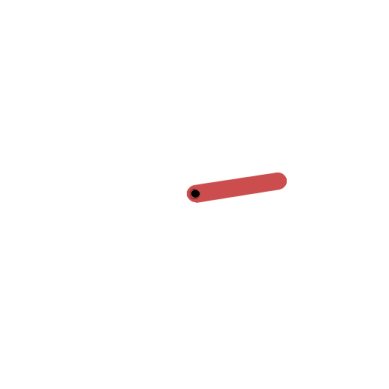

In [15]:
compute_avg_return(env, agent, num_episodes=10, render=True)
env.close()